<p style="text-align:right;">Mario Stanke, University of Greifswald, Germany</p>

# Solution to Exercise Set 1, Exercise 3 - A Different Loss

In this notebook you will learn how to customize the loss function that is used to fit a model to data. If the choice of the loss function does not align with the problem we want to solve,
we might end up with a model that has very low loss values, but is still behind our expectations.

We reconsider the bike rental problem with a different loss function. For the bike rental problem, we could say we have two kinds of errors: 

1. Prepare more bikes than necessary.
2. Prepare less likes than necessary.

Let again $t = h_{\pmb{\theta}}(x) := \theta_0 + \theta_1 x$ be the number of bikes we make ready depending on the (forecast) temperature $x = x_1$.

 1. If the demand $y$ exceeds the number of bikes made ready $t$, we incurr costs $5(y-t)$ for the lost revenue.
 2. If the bikes made ready $t$ exceed the demand $y$, we incurr costs $t-y$ for making the superfluous bikes ready.
 
Therefore, we *weight* both errors differently. 

We seek to find a $\pmb{\theta}$ that minimizes 
 $$L(\pmb{\theta}) = \frac{1}{m} \sum_{i=1}^m \ell(y_i, h_{\pmb{\theta}}(x^{(i)})),$$
where
$$ \ell(y, t) = 5 \cdot \texttt{relu}(y-t) + \texttt{relu}(t-y)$$
and 
$$\texttt{relu}(z):= \max\{z, 0\}$$
is the so-called *rectified linear unit*:

<img src="activ-relu.png" width="400"/>

Relu is a commonly used activation function already part of tensorflow: [tf.nn.relu](https://www.tensorflow.org/api_docs/python/tf/nn/relu).

### 1. Implement $\ell(y, t)$ with TensorFlow functions.

In [1]:
# First import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

Define the function ```ell``` to be used below.  
Tipps: [tf.nn.relu](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/nn/relu)

In [2]:
def ell(y, t):
    '''
        Input: y and t are vectors of the same size.
        Output: vector of 5 * relu(y-t) + relu(t-y) applied to each component of y and t
    '''
    # ADD YOUR CODE HERE, 1 line, replace this line
    return tf.zeros_like(y)

In [3]:
# test the function
np.random.seed(1) # so the whole class uses the same pseudorandom numbers

t1 = tf.constant(np.random.randint(low=0, high=5, size=4), dtype='float64') # bikes ready
y1 = tf.constant(np.random.randint(low=0, high=8, size=4), dtype='float64') # bike demand

losses = ell(y1, t1)
print("t =", t1.numpy(),
      "\ny =", y1.numpy(),
      "\nlosses =", losses.numpy())

t = [3. 4. 0. 1.] 
y = [3. 5. 7. 0.] 
losses = [0. 0. 0. 0.]


**Solution:**
```
t = [3. 4. 0. 1.] 
y = [3. 5. 7. 0.] 
losses = [ 0.  5. 35.  1.]
```

## 2. Make TensorFlow use your loss
 1. Below code is a copy of the relevant parts from todays lecture. First, execute everything as is, e.g. using Kernel->Restart & Run All.
 2. Go to the function ```train_step``` and replace your own loss function where the code is marked YOUR CODE HERE.


In [4]:
# load the training data from the table file to a pandas data frame
df = pd.read_csv("bikes-summerdays.tbl", sep='\s+')
df['count'] = df['count'].astype(float) # convert count data to floats
m, n_cols = df.shape # training set size and number of columns

In [5]:
def scatterplot_rentals():
    ''' Plot the bike rental counts versus the temperature.'''
    _, ax = plt.subplots()
    ax.scatter(df["temp"], df["count"])
    plt.title("bike rentals versus temperature")
    plt.xlabel('temperature [' + r'$^\circ$' + 'C]')
    plt.ylabel('rental count per hour');
    return ax

## Create Data Matrix $X$ and response vector $y$

In [6]:
# extract response vector
y_train = np.array(df['count']) 

# extract feature columns
n = n_cols - 1 # number of features
temps = np.array(df.loc[:, df.columns != 'count']) # matrix of all other columns (here only one col)

# make data matrix X
X_train = np.ones((m, n+1)) # initialize with all ones
X_train[:,1:n+1] = temps / 10 - 2.5 # normalize temperatures so they are roughly in [-1,1] 

## Training

#### Define your own loss function here
*Tip:* [tf.reduce_mean](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/math/reduce_mean?hl=en)

In [7]:
#loss functions for supervised learning in tensorflow always have the form true values first, predictions after
def loss_fkt(y_true, y_pred):
    ''' Returns the mean loss according to function ell'''
    # YOUR CODE HERE, replace the following line with a call to your own loss function ell
    # REMEMBER TO take the average, too, so E is a scalar.
    E = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    # END OF YOUR CODE
    return E

#### Test of ```loss_fkt```

In [8]:
np.random.seed(1)

t1 = tf.constant(np.random.randint(low=0, high=5, size=4), dtype='float64') # bikes ready
y1 = tf.constant(np.random.randint(low=0, high=8, size=4), dtype='float64') # bike demand

E = loss_fkt(y1, t1)
print("t =", t1.numpy(),
      "\ny =", y1.numpy(),
      "\nE =", E.numpy())

t = [3. 4. 0. 1.] 
y = [3. 5. 7. 0.] 
E = 12.75


**Solution:**
```
t = [3. 4. 0. 1.] 
y = [3. 5. 7. 0.] 
E = 10.25
```

In [9]:
optimizer = tf.keras.optimizers.SGD(learning_rate = .1, momentum = 0.8)

In [10]:
# same code as in previous notebook
dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
dataset = dataset.shuffle(m).batch(32) 
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(
    units = 1, input_dim = 2,
    use_bias = False, # bias equivalent to adding x_0 := 1
    dtype = 'float64'))

#YOUR CODE HERE
#replace the MSE below with your own loss function
model.compile(optimizer = optimizer, loss = tf.keras.losses.MeanSquaredError())

# same code as in previous notebook
class CustomCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        self.theta = []
    
    def on_epoch_end(self, batch, logs=None):
        self.theta.append(tf.squeeze(model.get_weights()[0]))
callback = CustomCallback()
history = model.fit(dataset, epochs=10, callbacks=[callback])

Epoch 1/10
47/47 [==============================] - 1s 645us/step - loss: 35343.2695
Epoch 2/10
47/47 [==============================] - 0s 680us/step - loss: 27656.4434
Epoch 3/10
47/47 [==============================] - 0s 691us/step - loss: 27969.6348
Epoch 4/10
47/47 [==============================] - 0s 668us/step - loss: 27658.5742
Epoch 5/10
47/47 [==============================] - 0s 702us/step - loss: 27841.4707
Epoch 6/10
47/47 [==============================] - 0s 677us/step - loss: 27992.4512
Epoch 7/10
47/47 [==============================] - 0s 682us/step - loss: 27740.6992
Epoch 8/10
47/47 [==============================] - 0s 684us/step - loss: 27763.6484
Epoch 9/10
47/47 [==============================] - 0s 717us/step - loss: 27496.5293
Epoch 10/10
47/47 [==============================] - 0s 683us/step - loss: 27901.3770


In [11]:
print("theta:\n", model.trainable_variables[0].numpy())
# make final prediction on all training data
y_pred = tf.reshape(model(X_train), [m])
print ("Loss = ", loss_fkt(y_train, y_pred))

theta:
 [[287.90757615]
 [121.80538138]]
Loss =  tf.Tensor(28007.203125, shape=(), dtype=float64)


## Plot predictions

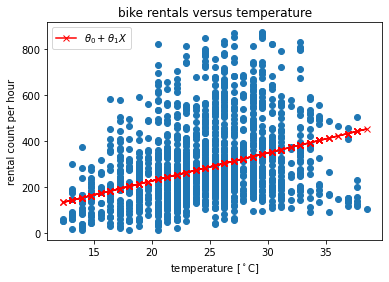

In [12]:
# draw the same scatterplot as above
ax = scatterplot_rentals()

# now add the predictions, here a regression line
ax.plot(temps, y_pred, 'rx-', label=r"$\theta_0 + \theta_1 X$") # - draws line connecting (r)ed crosses (x)
ax.legend(loc = 'upper left');

After you have solved the exercise correctly, the regression line will have moved up a bit compared to the regular regression line (ending above 600 bikes at maximal temperature). This is due to the fact that the differences to the $y$-values above the line are penalized more. 